In [3]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [4]:
class GridWorld:
    def __init__(self, taille=[6, 6], position_start=[0, 1], good_end_position=[4, 2], bad_end_position=[3, 5]):
        self.current_state = position_start  # État actuel (ligne, colonne)
        self.states = [[x, y] for x in range(taille[0]) for y in range(taille[1])]
        self.end_good_state = good_end_position  # État final (ligne, colonne)
        self.end_bad_state = bad_end_position
        self.grid_size = taille  # Taille de la grille (lignes, colonnes)
        self.stateSpace = {}
        self.matchStates()
        self.currentIntState = self.getStateInt(self.current_state)
        self.num_actions = 4  # Nombre total d'actions possibles (haut, bas, gauche, droite)
        self.reward = 0  # Récompense actuelle
        self.done = False  # Indique si la partie est terminée
        self.generate_grid()
        self.actions = [0, 1, 2, 3]
        self.rewards = [0, 1, 3]
        self.actionSpace = {0: -self.grid_size[0], 1: self.grid_size[0],
                            2: -1, 3: 1}

    def state_description(self):
        return np.array([self.currentIntState / (len(self.states) - 1) * 2.0 - 1.0])

    def state_dim(self):
        return len(self.state_description())

    def reset(self):
        self.done = False
        self.current_state = [np.random.randint(0, self.grid_size[0] - 1), np.random.randint(0, self.grid_size[1] - 1)]
        self.currentIntState = self.getStateInt(self.current_state)
        self.reward = 0

    def matchStates(self):
        i = 0
        for s in self.states:
            self.stateSpace[str(s)] = i
            i = i + 1

    def getStateInt(self, st):
        return self.stateSpace[str(st)]

    def getStateCouple(self, st):
        n_state = {i for i in self.stateSpace if self.stateSpace[i] == st}
        return list(n_state)

    def step(self, action):
        if action == 0:
            if self.current_state[0] == 0:
                self.current_state[0] = self.grid_size[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour traverser le mur
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[0] = self.current_state[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 1:
            if self.current_state[0] == self.grid_size[0] - 1:
                self.current_state[0] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[0] = self.current_state[0] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 2:
            if self.current_state[1] == 0:
                self.current_state[1] = self.grid_size[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 3:
            if self.current_state[1] == self.grid_size[1] - 1:
                self.current_state[1] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                # print(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
                # Si l'on atteint l'état final, la partie est terminée
        return self.currentIntState, self.reward, self.done

    def endgame(self):
        if self.current_state == self.end_good_state:
            self.reward = 10  # Récompense de 10 pour atteindre l'état final
            self.done = True
            print("Une bonne récompense")
        elif self.current_state == self.end_bad_state:
            self.reward = -10
            self.done = True
            print("Une mauvaise récompense")

    def generate_grid(self):
        grid = []
        for i in range(self.grid_size[0]):
            grid.append([])
            for j in range(self.grid_size[1]):
                grid[i].append("_")
        grid[self.current_state[0]][self.current_state[1]] = "X"
        for i in grid:
            print(i)
        print("\n")

In [5]:
def REINFORCE_with_mean_baseline(env, max_iter_count: int = 10000,
                                  gamma: float = 0.99,
                                  alpha_pi: float = 0.01,
                                  alpha_v: float = 0.01):
    pi = tf.keras.models.Sequential()
    pi.add(tf.keras.layers.Dense(len(env.actions),
                                 activation=tf.keras.activations.softmax,
                                 use_bias=True
                                 ))


    ema_score = 0.0
    ema_nb_steps = 0.0
    first_episode = True

    step = 0
    ema_score_progress = []
    ema_nb_steps_progress = []

    episode_states_buffer = []
    episode_actions_buffer = []
    episode_rewards_buffer = []
    
    mean_baseline = 0.0

    for _ in tqdm(range(max_iter_count)):
        if env.done:
            ### TRAINING TIME !!!
            G = 0.0

            for t in reversed(range(0, len(episode_states_buffer))):
                G = episode_rewards_buffer[t] + gamma * G

                delta = G - mean_baseline
                

                with tf.GradientTape() as tape_pi:
                    pi_s_a_t = pi(np.array([episode_states_buffer[t]]))[0][episode_actions_buffer[t]]
                    log_pi_s_a_t = tf.math.log(pi_s_a_t)

                grads = tape_pi.gradient(log_pi_s_a_t, pi.trainable_variables)

                for (var, grad) in zip(pi.trainable_variables, grads):
                    if grad is not None:
                        var.assign_add(alpha_pi * (gamma ** t) * delta * grad)

            mean_baseline = ((mean_baseline * step) + G) / (step + 1)
            
            if first_episode:
                ema_score = env.reward
                ema_nb_steps = step
                first_episode = False
            else:
                ema_score = (1 - 0.95) * env.reward + 0.95 * ema_score
                ema_nb_steps = (1 - 0.95) * step + 0.95 * ema_nb_steps
                ema_score_progress.append(ema_score)
                ema_nb_steps_progress.append(ema_nb_steps)

            env.reset()
            episode_states_buffer.clear()
            episode_actions_buffer.clear()
            episode_rewards_buffer.clear()
            step = 0

        s = env.state_description()

        episode_states_buffer.append(s)

        aa = env.actions

        pi_s = pi(np.array([s]))[0].numpy()
        allowed_pi_s = pi_s[aa]
        sum_allowed_pi_s = np.sum(allowed_pi_s)
        if sum_allowed_pi_s == 0.0:
            probs = np.ones((len(aa),)) * 1.0 / (len(aa))
        else:
            probs = allowed_pi_s / sum_allowed_pi_s

        a = np.random.choice(aa, p=probs)

        episode_actions_buffer.append(a)

        old_score = env.reward
        env.step(a)
        new_score = env.reward
        r = new_score - old_score

        episode_rewards_buffer.append(r)

        step += 1
    return pi, mean_baseline, ema_score_progress, ema_nb_steps_progress


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']




  0%|                                                                               | 12/10000 [00:00<02:45, 60.45it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  0%|▎                                                                             | 41/10000 [00:00<01:02, 159.52it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  1%|▍                                                                             | 58/10000 [00:00<01:33, 106.22it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  1%|▋                                                                             | 93/10000 [00:00<01:33, 105.72it/s]

['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  1%|█                                                                            | 146/10000 [00:01<00:56, 175.60it/s]

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  2%|█▎                                                                           | 174/10000 [00:01<00:48, 202.49it/s]


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_

  2%|█▌                                                                            | 197/10000 [00:01<01:38, 99.88it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  3%|█▉                                                                           | 257/10000 [00:02<01:09, 139.58it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  3%|██▍                                                                          | 319/10000 [00:02<00:48, 197.98it/s]

['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  4%|██▉                                                                          | 381/10000 [00:02<01:13, 130.00it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  4%|███▍                                                                         | 443/10000 [00:03<00:51, 185.02it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_'

  5%|███▉                                                                         | 505/10000 [00:03<00:40, 233.46it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  6%|████▍                                                                        | 569/10000 [00:03<00:34, 269.60it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  6%|████▋                                                                         | 600/10000 [00:04<02:10, 72.06it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_

  7%|█████                                                                        | 662/10000 [00:05<01:28, 105.77it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  7%|█████▌                                                                       | 726/10000 [00:05<00:57, 160.87it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  8%|██████                                                                       | 790/10000 [00:05<00:42, 215.18it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  8%|██████▍                                                                       | 820/10000 [00:06<01:50, 83.37it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  9%|██████▋                                                                      | 869/10000 [00:06<01:28, 103.62it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_',

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

  9%|███████                                                                      | 920/10000 [00:07<01:21, 110.99it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 10%|███████▌                                                                     | 977/10000 [00:07<00:56, 160.04it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 10%|███████▋                                                                     | 1001/10000 [00:08<01:48, 82.63it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 11%|███████▉                                                                    | 1051/10000 [00:08<01:19, 112.88it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 11%|████████▍                                                                   | 1113/10000 [00:08<00:51, 173.50it/s]

['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 12%|████████▉                                                                   | 1173/10000 [00:08<00:39, 222.84it/s]

['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 12%|█████████▏                                                                  | 1201/10000 [00:08<00:39, 221.16it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 13%|█████████▌                                                                  | 1253/10000 [00:09<00:39, 222.36it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 13%|█████████▉                                                                  | 1314/10000 [00:09<00:33, 257.78it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 13%|██████████▏                                                                 | 1342/10000 [00:09<00:33, 258.91it/s]

['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 14%|██████████▋                                                                 | 1403/10000 [00:09<00:30, 279.44it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 15%|███████████                                                                 | 1463/10000 [00:09<00:31, 271.02it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_'

 15%|███████████▎                                                                | 1491/10000 [00:10<00:32, 259.00it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 15%|███████████▋                                                                | 1546/10000 [00:10<00:33, 254.87it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 16%|████████████▎                                                                | 1604/10000 [00:13<03:23, 41.30it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 17%|████████████▊                                                                | 1656/10000 [00:13<02:00, 69.01it/s]

['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 17%|████████████▉                                                                | 1680/10000 [00:13<01:40, 83.17it/s]

['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 17%|█████████████▏                                                              | 1741/10000 [00:13<01:00, 137.14it/s]

['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 18%|█████████████▋                                                              | 1796/10000 [00:14<00:45, 179.98it/s]

['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 19%|██████████████                                                              | 1851/10000 [00:14<00:38, 213.92it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 19%|██████████████▎                                                             | 1878/10000 [00:14<00:36, 225.60it/s]

['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 19%|██████████████▍                                                             | 1905/10000 [00:14<00:35, 225.41it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 19%|██████████████▊                                                              | 1931/10000 [00:16<03:15, 41.34it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_

 20%|███████████████▏                                                             | 1977/10000 [00:16<02:00, 66.60it/s]

['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 20%|███████████████▌                                                             | 2019/10000 [00:16<01:22, 96.79it/s]

['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 20%|███████████████▋                                                             | 2039/10000 [00:17<02:34, 51.38it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 21%|███████████████▉                                                             | 2070/10000 [00:17<01:50, 71.63it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 21%|████████████████                                                            | 2107/10000 [00:18<01:16, 102.97it/s]

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_'

 21%|████████████████▎                                                           | 2145/10000 [00:18<00:59, 133.01it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 22%|████████████████▋                                                           | 2190/10000 [00:18<00:45, 170.54it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 22%|█████████████████▏                                                           | 2230/10000 [00:19<02:11, 59.31it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 23%|█████████████████▎                                                          | 2276/10000 [00:20<01:16, 100.40it/s]



['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '

 23%|█████████████████▋                                                          | 2333/10000 [00:20<00:48, 158.50it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 24%|█████████████████▉                                                          | 2357/10000 [00:20<00:45, 166.91it/s]

['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_'

 24%|██████████████████▌                                                          | 2409/10000 [00:21<01:30, 84.30it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 25%|██████████████████▊                                                         | 2468/10000 [00:21<00:54, 138.00it/s]

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 25%|██████████████████▉                                                         | 2494/10000 [00:21<00:47, 159.07it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 25%|███████████████████▎                                                        | 2543/10000 [00:22<00:42, 174.96it/s]

['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 26%|███████████████████▊                                                        | 2599/10000 [00:22<00:33, 220.11it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 26%|███████████████████▉                                                        | 2628/10000 [00:22<00:30, 238.08it/s]

['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 27%|████████████████████▏                                                       | 2655/10000 [00:22<00:31, 231.13it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 27%|████████████████████▊                                                        | 2703/10000 [00:24<02:09, 56.23it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 27%|████████████████████▉                                                        | 2723/10000 [00:24<02:12, 54.76it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 28%|█████████████████████▎                                                       | 2775/10000 [00:25<01:35, 75.34it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 28%|█████████████████████▎                                                      | 2808/10000 [00:25<01:08, 104.41it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_'

 29%|█████████████████████▊                                                      | 2872/10000 [00:25<00:43, 164.78it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 29%|██████████████████████▎                                                     | 2933/10000 [00:26<00:59, 119.05it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 30%|██████████████████████▊                                                     | 3000/10000 [00:26<00:38, 180.93it/s]

['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 31%|███████████████████████▎                                                    | 3063/10000 [00:26<00:30, 229.76it/s]

['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 31%|███████████████████████▋                                                    | 3124/10000 [00:26<00:26, 261.53it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense


 32%|████████████████████████▎                                                    | 3155/10000 [00:28<01:49, 62.70it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 32%|████████████████████████▋                                                    | 3204/10000 [00:28<01:27, 78.04it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_',

 32%|████████████████████████▋                                                   | 3250/10000 [00:28<01:06, 101.94it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 33%|█████████████████████████                                                   | 3300/10000 [00:29<00:54, 122.19it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_'

 34%|█████████████████████████▌                                                  | 3361/10000 [00:29<00:36, 183.56it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense


 34%|██████████████████████████                                                  | 3422/10000 [00:30<00:56, 115.73it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 35%|██████████████████████████▍                                                 | 3481/10000 [00:30<00:52, 123.69it/s]

['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense


 35%|██████████████████████████▊                                                 | 3531/10000 [00:31<00:49, 131.35it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 36%|███████████████████████████                                                 | 3560/10000 [00:31<00:40, 157.82it/s]

['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 36%|███████████████████████████▍                                                | 3615/10000 [00:32<00:50, 126.54it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_

 37%|███████████████████████████▉                                                | 3680/10000 [00:32<00:33, 190.71it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 37%|████████████████████████████▏                                               | 3708/10000 [00:32<00:58, 107.40it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 37%|████████████████████████████▍                                               | 3748/10000 [00:33<00:53, 117.76it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 38%|████████████████████████████▉                                                | 3766/10000 [00:33<01:06, 94.17it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 38%|████████████████████████████▊                                               | 3790/10000 [00:33<00:54, 114.99it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 38%|█████████████████████████████▏                                              | 3840/10000 [00:33<00:50, 122.17it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 39%|█████████████████████████████▋                                               | 3859/10000 [00:34<01:08, 90.26it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 39%|█████████████████████████████▋                                              | 3907/10000 [00:34<00:49, 123.14it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 39%|██████████████████████████████▏                                              | 3926/10000 [00:34<01:03, 95.56it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 39%|█████████████████████████████▉                                              | 3943/10000 [00:35<00:56, 106.83it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_'

 40%|██████████████████████████████▌                                              | 3973/10000 [00:35<01:03, 94.44it/s]

['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 40%|██████████████████████████████▋                                              | 3986/10000 [00:35<01:00, 99.91it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_

 40%|██████████████████████████████▌                                             | 4020/10000 [00:35<00:40, 148.42it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_'

 40%|██████████████████████████████▋                                             | 4039/10000 [00:35<00:59, 101.01it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 41%|██████████████████████████████▉                                             | 4072/10000 [00:36<00:42, 139.70it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 41%|███████████████████████████████▎                                            | 4115/10000 [00:36<00:55, 106.46it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_

 41%|███████████████████████████████▍                                            | 4134/10000 [00:36<00:53, 110.52it/s]

['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 42%|███████████████████████████████▌                                            | 4152/10000 [00:36<00:47, 122.23it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 42%|███████████████████████████████▊                                            | 4189/10000 [00:37<00:46, 125.45it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 42%|████████████████████████████████                                            | 4221/10000 [00:37<00:34, 167.17it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 43%|████████████████████████████████▍                                           | 4265/10000 [00:37<00:49, 116.22it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 43%|████████████████████████████████▉                                           | 4332/10000 [00:38<00:29, 192.18it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 44%|█████████████████████████████████                                           | 4357/10000 [00:38<00:30, 182.09it/s]

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_'

 44%|█████████████████████████████████▎                                          | 4379/10000 [00:38<00:31, 181.24it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_'

 44%|██████████████████████████████████                                           | 4416/10000 [00:39<01:17, 72.48it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_'

 44%|██████████████████████████████████▏                                          | 4442/10000 [00:39<00:58, 95.64it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 45%|██████████████████████████████████▎                                          | 4460/10000 [00:39<01:01, 89.66it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_'

 45%|██████████████████████████████████▏                                         | 4492/10000 [00:39<00:53, 102.44it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 45%|██████████████████████████████████▌                                         | 4547/10000 [00:40<00:39, 137.18it/s]


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense


 46%|██████████████████████████████████▊                                         | 4577/10000 [00:40<00:53, 100.65it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 46%|███████████████████████████████████▏                                        | 4627/10000 [00:41<00:42, 125.98it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 47%|███████████████████████████████████▌                                        | 4675/10000 [00:41<00:39, 134.57it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 47%|███████████████████████████████████▊                                        | 4708/10000 [00:41<00:31, 170.07it/s]

['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 47%|████████████████████████████████████                                        | 4749/10000 [00:42<00:49, 106.96it/s]

['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X'

 48%|████████████████████████████████████▎                                       | 4786/10000 [00:42<00:49, 106.02it/s]

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 48%|████████████████████████████████████▍                                       | 4800/10000 [00:42<00:48, 107.12it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_

 48%|████████████████████████████████████▊                                       | 4844/10000 [00:42<00:39, 131.71it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 49%|█████████████████████████████████████▏                                      | 4896/10000 [00:43<00:27, 182.39it/s]

['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 50%|█████████████████████████████████████▌                                      | 4950/10000 [00:43<00:22, 222.99it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 50%|█████████████████████████████████████▉                                      | 4984/10000 [00:43<00:19, 252.57it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 50%|██████████████████████████████████████▌                                      | 5011/10000 [00:44<01:03, 78.41it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 50%|██████████████████████████████████████▋                                      | 5031/10000 [00:44<01:00, 82.65it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 51%|██████████████████████████████████████▌                                     | 5068/10000 [00:44<00:48, 101.31it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 51%|██████████████████████████████████████▋                                     | 5097/10000 [00:44<00:37, 131.69it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 51%|███████████████████████████████████████▍                                     | 5117/10000 [00:45<00:55, 87.48it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_',

 52%|███████████████████████████████████████▏                                    | 5156/10000 [00:45<00:45, 105.88it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 52%|███████████████████████████████████████▎                                    | 5177/10000 [00:45<00:38, 124.17it/s]




['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', 

 52%|███████████████████████████████████████▊                                    | 5232/10000 [00:46<00:32, 144.74it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_',

 53%|████████████████████████████████████████▎                                   | 5301/10000 [00:46<00:21, 219.96it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_'

 53%|████████████████████████████████████████▍                                   | 5328/10000 [00:46<00:41, 112.42it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 53%|████████████████████████████████████████▋                                   | 5349/10000 [00:47<00:43, 107.86it/s]

['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 54%|████████████████████████████████████████▉                                   | 5382/10000 [00:47<00:32, 140.03it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense


 54%|█████████████████████████████████████████                                   | 5404/10000 [00:47<00:44, 102.40it/s]

['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X'

 54%|█████████████████████████████████████████▏                                  | 5426/10000 [00:47<00:41, 109.32it/s]


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X

 55%|█████████████████████████████████████████▋                                  | 5492/10000 [00:47<00:25, 177.27it/s]


['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 

 56%|██████████████████████████████████████████▏                                 | 5558/10000 [00:48<00:18, 236.54it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense


 56%|███████████████████████████████████████████                                  | 5587/10000 [00:49<00:52, 83.51it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_

 56%|███████████████████████████████████████████▏                                 | 5609/10000 [00:49<00:50, 87.52it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 56%|███████████████████████████████████████████▍                                 | 5644/10000 [00:49<00:47, 92.18it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 57%|███████████████████████████████████████████                                 | 5661/10000 [00:49<00:41, 103.49it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 57%|███████████████████████████████████████████▊                                 | 5694/10000 [00:50<00:48, 88.55it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 57%|███████████████████████████████████████████▌                                | 5727/10000 [00:50<00:38, 110.56it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 57%|███████████████████████████████████████████▋                                | 5746/10000 [00:50<00:33, 127.50it/s]

['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 58%|████████████████████████████████████████████▎                                | 5762/10000 [00:51<01:10, 59.80it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_

 58%|████████████████████████████████████████████▌                                | 5795/10000 [00:51<00:53, 77.88it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 58%|████████████████████████████████████████████▉                                | 5833/10000 [00:51<00:47, 88.11it/s]

['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 59%|████████████████████████████████████████████▌                               | 5856/10000 [00:52<00:36, 112.52it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_'

 59%|█████████████████████████████████████████████▍                               | 5895/10000 [00:52<00:46, 88.18it/s]

['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 59%|█████████████████████████████████████████████▌                               | 5923/10000 [00:52<00:40, 99.58it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_',

 59%|█████████████████████████████████████████████▏                              | 5945/10000 [00:52<00:32, 123.37it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 60%|██████████████████████████████████████████████                               | 5977/10000 [00:53<00:42, 93.98it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_',

 60%|█████████████████████████████████████████████▌                              | 5991/10000 [00:53<00:38, 102.88it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 60%|█████████████████████████████████████████████▊                              | 6035/10000 [00:53<00:32, 122.63it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 61%|██████████████████████████████████████████████▌                              | 6052/10000 [00:54<00:42, 92.37it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 61%|██████████████████████████████████████████████▋                              | 6066/10000 [00:54<00:42, 92.02it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 61%|██████████████████████████████████████████████▌                             | 6123/10000 [00:54<00:30, 127.61it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 62%|██████████████████████████████████████████████▊                             | 6167/10000 [00:55<00:29, 128.32it/s]

['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 62%|███████████████████████████████████████████████                             | 6195/10000 [00:55<00:24, 157.52it/s]




['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 

 62%|███████████████████████████████████████████████▊                             | 6216/10000 [00:55<00:42, 88.68it/s]

['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 62%|███████████████████████████████████████████████▍                            | 6238/10000 [00:55<00:35, 106.53it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 63%|███████████████████████████████████████████████▌                            | 6260/10000 [00:55<00:29, 125.27it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 63%|████████████████████████████████████████████████▍                            | 6294/10000 [00:56<00:44, 83.55it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 63%|████████████████████████████████████████████████▊                            | 6335/10000 [00:57<00:39, 93.78it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_'

 64%|████████████████████████████████████████████████▎                           | 6357/10000 [00:57<00:31, 114.43it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 64%|█████████████████████████████████████████████████                            | 6374/10000 [00:57<00:47, 76.44it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 64%|█████████████████████████████████████████████████▎                           | 6402/10000 [00:57<00:44, 80.82it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense
['_', '_', '_', '_', '_', '_']
['X',

 64%|████████████████████████████████████████████████▉                           | 6439/10000 [00:58<00:31, 113.17it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 65%|█████████████████████████████████████████████████                           | 6454/10000 [00:58<00:29, 119.10it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 65%|█████████████████████████████████████████████████▉                           | 6492/10000 [00:58<00:41, 84.54it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_

 65%|█████████████████████████████████████████████████▋                          | 6535/10000 [00:59<00:32, 107.38it/s]

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 66%|█████████████████████████████████████████████████▊                          | 6555/10000 [00:59<00:27, 123.68it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 66%|██████████████████████████████████████████████████▌                          | 6573/10000 [00:59<00:46, 73.53it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 66%|██████████████████████████████████████████████████▏                         | 6611/10000 [01:00<00:31, 107.43it/s]

['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense


 67%|███████████████████████████████████████████████████▎                         | 6658/10000 [01:00<00:34, 96.37it/s]

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 67%|██████████████████████████████████████████████████▉                         | 6705/10000 [01:00<00:23, 138.82it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 67%|███████████████████████████████████████████████████▏                        | 6732/10000 [01:00<00:19, 165.76it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 68%|███████████████████████████████████████████████████▍                        | 6762/10000 [01:01<00:16, 196.71it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 68%|███████████████████████████████████████████████████▊                        | 6815/10000 [01:01<00:30, 104.94it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 69%|████████████████████████████████████████████████████▏                       | 6865/10000 [01:02<00:20, 149.89it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 69%|████████████████████████████████████████████████████▌                       | 6920/10000 [01:02<00:24, 125.72it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 70%|████████████████████████████████████████████████████▉                       | 6963/10000 [01:03<00:27, 109.76it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 70%|█████████████████████████████████████████████████████▎                      | 7020/10000 [01:03<00:17, 166.95it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 71%|█████████████████████████████████████████████████████▋                      | 7065/10000 [01:03<00:25, 116.65it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 71%|██████████████████████████████████████████████████████                      | 7111/10000 [01:04<00:25, 112.98it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 72%|██████████████████████████████████████████████████████▍                     | 7165/10000 [01:04<00:17, 158.78it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 72%|██████████████████████████████████████████████████████▊                     | 7209/10000 [01:05<00:25, 109.62it/s]

['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 73%|███████████████████████████████████████████████████████▏                    | 7263/10000 [01:05<00:16, 164.89it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 73%|███████████████████████████████████████████████████████▍                    | 7287/10000 [01:05<00:15, 179.87it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 73%|███████████████████████████████████████████████████████▊                    | 7339/10000 [01:05<00:12, 211.41it/s]


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_

 74%|████████████████████████████████████████████████████████▏                   | 7391/10000 [01:05<00:11, 233.65it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 74%|████████████████████████████████████████████████████████▎                   | 7417/10000 [01:06<00:11, 221.87it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 75%|█████████████████████████████████████████████████████████▌                   | 7473/10000 [01:07<00:32, 76.77it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense


 75%|█████████████████████████████████████████████████████████▉                   | 7527/10000 [01:07<00:25, 96.31it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_

 76%|█████████████████████████████████████████████████████████▋                  | 7583/10000 [01:08<00:16, 144.98it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 76%|█████████████████████████████████████████████████████████▊                  | 7608/10000 [01:08<00:15, 154.53it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 77%|██████████████████████████████████████████████████████████▏                 | 7653/10000 [01:08<00:13, 173.12it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 77%|██████████████████████████████████████████████████████████▎                 | 7675/10000 [01:08<00:12, 179.39it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 77%|███████████████████████████████████████████████████████████▌                 | 7728/10000 [01:09<00:27, 81.54it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 78%|███████████████████████████████████████████████████████████▏                | 7789/10000 [01:09<00:16, 137.18it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 78%|███████████████████████████████████████████████████████████▋                | 7848/10000 [01:10<00:19, 112.06it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_

 79%|███████████████████████████████████████████████████████████▊                | 7872/10000 [01:10<00:21, 100.93it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 79%|████████████████████████████████████████████████████████████▊                | 7898/10000 [01:11<00:21, 99.77it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']




 79%|████████████████████████████████████████████████████████████▎               | 7928/10000 [01:11<00:16, 126.67it/s]

['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 80%|████████████████████████████████████████████████████████████▋               | 7981/10000 [01:11<00:13, 150.89it/s]

['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense


 80%|████████████████████████████████████████████████████████████▊               | 8003/10000 [01:12<00:18, 109.28it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une mauvaise récompense
['_', '_', 'X', '_', '_', '_']
['_',

 81%|█████████████████████████████████████████████████████████████▏              | 8052/10000 [01:12<00:13, 144.50it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_

 81%|█████████████████████████████████████████████████████████████▍              | 8081/10000 [01:12<00:11, 172.53it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 81%|█████████████████████████████████████████████████████████████▊              | 8137/10000 [01:12<00:13, 138.75it/s]

['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 82%|██████████████████████████████████████████████████████████████▎             | 8191/10000 [01:13<00:12, 148.15it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 83%|██████████████████████████████████████████████████████████████▋             | 8252/10000 [01:13<00:08, 203.92it/s]



['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '

 83%|███████████████████████████████████████████████████████████████▏            | 8313/10000 [01:13<00:06, 247.02it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 84%|███████████████████████████████████████████████████████████████▋            | 8374/10000 [01:13<00:05, 272.16it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 84%|████████████████████████████████████████████████████████████████▋            | 8404/10000 [01:15<00:22, 70.72it/s]

['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 85%|█████████████████████████████████████████████████████████████████            | 8452/10000 [01:15<00:16, 94.95it/s]

['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 85%|████████████████████████████████████████████████████████████████▋           | 8515/10000 [01:15<00:09, 153.51it/s]


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_

 85%|████████████████████████████████████████████████████████████████▉           | 8544/10000 [01:15<00:08, 178.18it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 86%|██████████████████████████████████████████████████████████████████▏          | 8594/10000 [01:16<00:14, 97.26it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_

 87%|█████████████████████████████████████████████████████████████████▊          | 8656/10000 [01:16<00:08, 155.79it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 87%|██████████████████████████████████████████████████████████████████▏         | 8715/10000 [01:16<00:06, 206.25it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 87%|██████████████████████████████████████████████████████████████████▍         | 8743/10000 [01:17<00:05, 221.76it/s]



['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '

 88%|██████████████████████████████████████████████████████████████████▉         | 8802/10000 [01:17<00:04, 248.59it/s]


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_

 88%|███████████████████████████████████████████████████████████████████         | 8830/10000 [01:17<00:04, 251.59it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 89%|████████████████████████████████████████████████████████████████████▍        | 8891/10000 [01:18<00:11, 92.53it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 89%|███████████████████████████████████████████████████████████████████▊        | 8920/10000 [01:18<00:09, 115.34it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 90%|████████████████████████████████████████████████████████████████████▎       | 8982/10000 [01:18<00:05, 170.04it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 90%|████████████████████████████████████████████████████████████████████▍       | 9010/10000 [01:19<00:05, 190.59it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 91%|████████████████████████████████████████████████████████████████████▉       | 9069/10000 [01:20<00:09, 101.81it/s]

['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 91%|█████████████████████████████████████████████████████████████████████▍      | 9130/10000 [01:20<00:05, 155.74it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 92%|█████████████████████████████████████████████████████████████████████▊      | 9189/10000 [01:20<00:06, 116.40it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_'

 92%|██████████████████████████████████████████████████████████████████████▎     | 9245/10000 [01:21<00:05, 128.33it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 93%|██████████████████████████████████████████████████████████████████████▋     | 9306/10000 [01:21<00:03, 183.77it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 94%|███████████████████████████████████████████████████████████████████████▏    | 9366/10000 [01:21<00:02, 230.18it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 94%|███████████████████████████████████████████████████████████████████████▋    | 9425/10000 [01:22<00:02, 255.57it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 95%|███████████████████████████████████████████████████████████████████████▊    | 9454/10000 [01:22<00:02, 263.39it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 95%|████████████████████████████████████████████████████████████████████████▎   | 9516/10000 [01:22<00:01, 278.33it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 96%|████████████████████████████████████████████████████████████████████████▊   | 9578/10000 [01:22<00:01, 289.33it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 96%|█████████████████████████████████████████████████████████████████████████▎  | 9640/10000 [01:22<00:01, 294.94it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 97%|█████████████████████████████████████████████████████████████████████████▋  | 9702/10000 [01:22<00:00, 300.21it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 97%|█████████████████████████████████████████████████████████████████████████▉  | 9733/10000 [01:23<00:00, 291.16it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 98%|██████████████████████████████████████████████████████████████████████████▍ | 9795/10000 [01:23<00:00, 292.72it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 99%|██████████████████████████████████████████████████████████████████████████▉ | 9855/10000 [01:23<00:00, 295.70it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_'

 99%|███████████████████████████████████████████████████████████████████████████▎| 9917/10000 [01:23<00:00, 300.16it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

 99%|███████████████████████████████████████████████████████████████████████████▌| 9948/10000 [01:23<00:00, 276.22it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:23<00:00, 119.06it/s]

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_'

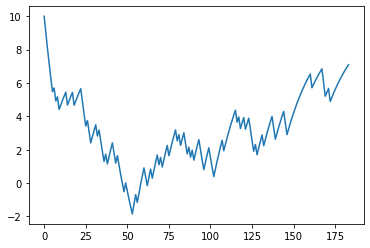

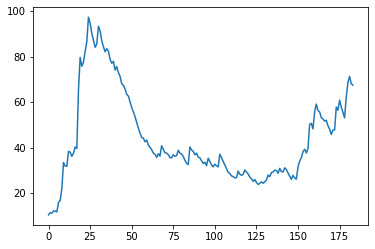

In [6]:
if __name__ == '__main__':
    world = GridWorld()
    pi, v, scores, steps = REINFORCE_with_mean_baseline(world)
    print(pi.weights)
    plt.plot(scores)
    plt.show()
    plt.plot(steps)
    plt.show()